# Import Libraries and Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re

import numpy as np
from functools import reduce
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn import linear_model
import torch
import torch.nn as nn
from tqdm import tqdm
import warnings

from scipy.stats import linregress
from sklearn.preprocessing import StandardScaler

In [2]:
DATA_PATH = '../data'
MODEL_PATH = '../src/models'

In [3]:
cons = pd.read_parquet(f'{DATA_PATH}/raw/q2_consDF_final.pqt')
acct = pd.read_parquet(f'{DATA_PATH}/raw/q2_acctDF_final.pqt')
inflows = pd.read_parquet(f'{DATA_PATH}/raw/q2_inflows_final.pqt')
outflows = pd.read_parquet(f'{DATA_PATH}/raw/q2_outflows_final.pqt')

# Create Features

In [4]:
features = []

### Max Balance at time of evaluation
The maximum balance a consumer has in any of their accounts at the time of evaluation

In [5]:
balance_var = acct[['prism_consumer_id','balance','balance_date']].groupby('prism_consumer_id').agg({
    'balance':['min', 'max', 'std'],
    'balance_date':['max']
}).reset_index()
balance_var.fillna(0.0, inplace=True)

balance_var.columns = balance_var.columns.to_flat_index().map(lambda x: x[1] + x[0])
features.append(balance_var)
balance_var.head()

,prism_consumer_id,minbalance,maxbalance,stdbalance,maxbalance_date
0,0,6182.60,9907.23,2633.711130,2023-04-13
1,2,8079.43,17426.83,6609.609926,2022-02-15
2,4,0.00,4871.39,2644.903088,2021-08-13
3,7,517.95,7071.18,3766.231217,2021-08-08
4,9,13348.76,13348.76,0.000000,2023-04-19


### Disposable Income
How much disposable income does a consumer have available after looking at all purchases and income sources in the dataset

In [6]:
cons_eval_dates = cons.sort_values('evaluation_date')[['prism_consumer_id','evaluation_date']]
outflow_merged = pd.merge(outflows, cons_eval_dates, on="prism_consumer_id", how="left")
inflow_merged = pd.merge(inflows, cons_eval_dates, on="prism_consumer_id", how="left")
outflow_merged['amount'] = outflow_merged['amount'] * -1
total_cashflow = pd.concat([inflow_merged, outflow_merged])

total_cashflow = total_cashflow[total_cashflow['posted_date'] <= total_cashflow['evaluation_date']]

total_balance = (
    total_cashflow[[
        'prism_consumer_id',
        'amount',
        'posted_date',
    ]]
    .groupby('prism_consumer_id')
    .agg({
        'amount':['sum'],
        'posted_date':['min','max']
    })
)

total_balance['date_range'] = pd.to_timedelta(total_balance['posted_date','max'] - total_balance['posted_date','min']).dt.days / 365
total_balance = pd.DataFrame({
    'total_balance': total_balance['amount','sum'] / total_balance['date_range'], 
    'total_balance_date': total_balance['posted_date', 'max']
}).reset_index()

features.append(total_balance)
total_balance.head()

,prism_consumer_id,total_balance,total_balance_date
0,0,15154.285773,2023-04-12
1,2,1546.065942,2022-02-14
2,4,3377.081389,2021-08-12
3,7,7311.445429,2021-08-06
4,9,5873.815289,2023-04-18


### Monthly Balance Statistics
Features that look at average monthly activity:
 - Average Monthly Spending
 - Average number of purchases made per month

In [7]:
outflow_valid = outflow_merged[outflow_merged['posted_date'] <= outflow_merged['evaluation_date']]
outflow_counts = outflow_valid.groupby('prism_consumer_id').agg({
    'amount':['count','sum'],
    'posted_date':['min','max'],
}).reset_index()

outflow_counts['date_range'] = pd.to_timedelta(outflow_counts['posted_date','max'] - outflow_counts['posted_date','min']).dt.days / 365 * 12

outflow_counts = pd.DataFrame({
    'prism_consumer_id': outflow_counts['prism_consumer_id'],
    'avg_monthly_spending': -1 * outflow_counts['amount','sum'] / outflow_counts['date_range'],
    'num_monthly_purchase': outflow_counts['amount','count'] / outflow_counts['date_range'],
    # 'monthly_purchase_date': outflow_counts['posted_date','max'],
})

outflow_counts.replace([np.inf, -np.inf], 0.0, inplace=True)
features.append(outflow_counts)
outflow_counts.head()

,prism_consumer_id,avg_monthly_spending,num_monthly_purchase
0,0,7703.614883,80.915055
1,2,9354.337258,98.743961
2,4,30563.426238,33.035880
3,7,23188.278116,138.265235
4,9,11186.144777,79.267677


### Savings Feature
A count of how many times someone has pulled from savings account


In [8]:
transfer_from_savings = inflows[inflows['category_description']=='SELF_TRANSFER']
transfer_from_savings = transfer_from_savings[transfer_from_savings['memo_clean'].str.contains('Savings')]
count_tfs = transfer_from_savings.groupby('prism_consumer_id').count().reset_index()
inflow_ids = pd.merge(inflows[['prism_consumer_id']], count_tfs, on='prism_consumer_id', how='left')
inflow_ids = inflow_ids.fillna(0).drop_duplicates(subset=['prism_consumer_id']).reset_index()[['prism_consumer_id', 'memo_clean']]

features.append(inflow_ids)
inflow_ids

,prism_consumer_id,memo_clean
0,0,0.0
1,2,0.0
2,4,0.0
3,7,0.0
4,9,0.0
...,...,...
2973,3991,63.0
2974,3992,0.0
2975,3993,22.0
2976,3996,241.0


### Unsufficient Funds
A boolean output for whether a consumer has an account that is negative or near 0.

In [9]:
acct['unsufficient_balance'] = acct['balance'].apply(lambda x: x <= 1)
unsufficient_accts = acct.groupby('prism_consumer_id')['unsufficient_balance'].count().reset_index()[['prism_consumer_id', 'unsufficient_balance']]

features.append(unsufficient_accts)
unsufficient_accts.head()


,prism_consumer_id,unsufficient_balance
0,0,2
1,2,2
2,4,3
3,7,3
4,9,1


### Amount of Accounts Per User
A number that represents the total number of accounts each consumer has.

In [10]:
acct = acct.rename(columns = {'prism_consumer_id':'grouping_prism_consumer_id'})
account_count = acct.groupby('grouping_prism_consumer_id')[['grouping_prism_consumer_id']].count()
account_count = account_count.rename(columns = {'grouping_prism_consumer_id':'account_count'}).reset_index()
account_count = account_count.rename(columns = {'grouping_prism_consumer_id': 'prism_consumer_id'})

features.append(account_count)
account_count.head()

,prism_consumer_id,account_count
0,0,2
1,2,2
2,4,3
3,7,3
4,9,1


### Non-Essential Ratio
The Non-Essential Ratio is a metric that represents the proportion of spending deemed non-essential relative to the total spending for a given consumer. This ratio is calculated by dividing the total spending in categories considered non-essential by the overall spending, including both essential and non-essential categories.

In [11]:
# a list of spending categories considered essential for each consumer.
essential_lst = ['ACCOUNT_FEES',
                 'GROCERIES','LOAN',
                 'CREDIT_CARD_PAYMENT',
                 'BILLS_UTILITIES',
                 'AUTOMOTIVE',
                 'INSURANCE',
                 'ESSENTIAL_SERVICES',
                 'HEALTHCARE_MEDICAL',
                 'PETS','TAX','RENT', 
                 'MORTGAGE', 'CHILD_DEPENDENTS']


In [12]:
# non-essential spending for each consumer based on the defined essential categories.
def non_essential_ratio(essential_lst, outflows):
    
    # Create a binary column indicating if the category is essential
    outflows = outflows.copy()
    outflows['essential'] = outflows['category_description'].isin(essential_lst).astype(int)
    
    # Calculate the non-essential ratio for each prism_consumer_id
    result = (
        outflows.groupby(['prism_consumer_id', 'essential'])['amount'].sum()
        .unstack(fill_value=0)
        .assign(non_ess_ratio=lambda x: x[0] / x.sum(axis=1))
        .reset_index()
    )
    
    id_lst = result['prism_consumer_id'].tolist()
    ess_ratio = result['non_ess_ratio'].tolist()
    df = pd.DataFrame({'prism_consumer_id': id_lst, 'non_ess_ratio': ess_ratio})
    
    return df


In [13]:
non_essential = non_essential_ratio(essential_lst, outflows)
features.append(non_essential)
non_essential.head()

,prism_consumer_id,non_ess_ratio
0,0,0.581717
1,2,0.509382
2,4,0.280896
3,7,0.646896
4,9,0.417012


### Standardized Balance Slope
Calculates the balance slope for each consumer by examining their monthly balances using the linregress method.

In [14]:
# Calculate the standardized balance slope for each consumer
def stdzd_bal_slp(total_cashflow, acct):    
    
    total_c = total_cashflow.copy()
    
    # Extract the month and year from the posted_date column
    total_c['month'] = pd.to_datetime(total_c['posted_date']).dt.month
    total_c['year'] = pd.to_datetime(total_c['posted_date']).dt.year
    
    # Group by consumer, year, and month to sum the amounts
    total_c = total_c.groupby(['prism_consumer_id', 'year', 'month'])['amount'].sum().reset_index()
    
    # Get unique consumer IDs
    unique_ids = total_c['prism_consumer_id'].unique()
    
    # Initialize an empty list to store calculated slopes
    slopes = []
    
    # Loop through unique consumer IDs
    for i in unique_ids:
        # Filter data for the current consumer ID
        id_ = total_c[total_c['prism_consumer_id'] == i]
        
        # Get the initial balance for the consumer
        start_point = acct[acct['grouping_prism_consumer_id'] == i]['balance'].sum()
        
        # Reverse the monthly amounts and calculate cumulative balance
        diff_reversed = id_['amount'].iloc[::-1].tolist()
        line = np.cumsum(np.concatenate([[start_point], -np.array(diff_reversed)]))[::-1]
        
        # Use linregress to find the slope of the cumulative balance
        slope, intercept, _, _, _ = linregress(np.arange(len(line)), line)
        
        # Append the calculated slope to the list
        slopes.append(slope)
    
    # Create a DataFrame with consumer IDs and corresponding slopes
    df = pd.DataFrame({'prism_consumer_id': unique_ids, 'stdzd_bal_slp': slopes})
    
    # Standardize the slope values using StandardScaler
    features = df[['stdzd_bal_slp']]
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    scaled_df = pd.DataFrame(scaled_features, columns=features.columns)    
  
    return pd.concat([df[['prism_consumer_id']], scaled_df], axis=1)


In [15]:
slop = stdzd_bal_slp(total_cashflow, acct)
features.append(slop)
slop.head()

,prism_consumer_id,stdzd_bal_slp
0,0,0.374371
1,2,0.007861
2,4,0.540605
3,7,0.346054
4,9,0.195140


### Positive Remaining Ratio
Determines the amount of months where cashflow is positive out of all months in the dataset for each consumer

In [16]:
def get_PRR(total_cashflow):
    # Get month and year of inflow and outflow
    total_cashflow = total_cashflow.copy()
    total_cashflow['month'] = pd.to_datetime(total_cashflow['posted_date']).dt.month
    total_cashflow['year'] = pd.to_datetime(total_cashflow['posted_date']).dt.year
    # Group transactions by month and calculate remaining balance on each month for each client
    total_cashflow = total_cashflow.groupby(['prism_consumer_id', 'year', 'month'])['amount'].sum().reset_index()
    # Determine if the remaining amount is positive for each month
    total_cashflow['PRR'] = (total_cashflow['amount'] > 0).astype(int)
    # Calculate the ratio of months with positive remaining amounts
    total_cashflow = total_cashflow.groupby('prism_consumer_id')['PRR'].mean().reset_index()
    return total_cashflow

In [17]:
PRR = get_PRR(total_cashflow)
features.append(PRR)
PRR.head()

,prism_consumer_id,PRR
0,0,0.538462
1,2,0.333333
2,4,0.461538
3,7,0.384615
4,9,0.538462


### Credit Ratio
Determines the maximum number of consecutive months in which a consumer pays of a loan

In [18]:
def get_CR(outflows):
    # Get month range
    outflow_transactions = outflows.copy()
    outflow_transactions['month'] = pd.to_datetime(outflow_transactions['posted_date']).dt.month
    outflow_transactions['year'] = pd.to_datetime(outflow_transactions['posted_date']).dt.year
    outflow_transactions['date_id'] = 12 * (outflow_transactions['year'] - min(outflow_transactions['year'])) + outflow_transactions['month']
    # Get number of transactions for each category for each consumer
    cat_groups = outflow_transactions.groupby(['prism_consumer_id', 'date_id', 'category_description']).size().reset_index(name='count')
    # Find number of months where consumer spent money on credit card payments or loans
    cat_counts = cat_groups.groupby(['prism_consumer_id','category_description']).agg({'count':'count', 'date_id':['min', 'max']}).reset_index()
    credit_counts = cat_counts[np.isin(cat_counts['category_description'], ['LOAN', 'CREDIT_CARD_PAYMENT'])].copy()
    # Get maximum credit ratio
    credit_counts['CR'] = credit_counts['count','count'] / (credit_counts['date_id','max'] - credit_counts['date_id','min'] + 1)
    return credit_counts.groupby('prism_consumer_id')['CR'].max().reset_index()

In [19]:
CR = get_CR(outflows)
features.append(CR)
CR.head()

,prism_consumer_id,CR
0,0,1.0
1,2,1.0
2,4,1.0
3,7,1.0
4,9,1.0


### Tax Payment


In [20]:
def get_avg_tax_amt(outflows):
    return (
        outflows[outflows['category_description'] == 'TAX']
        .groupby('prism_consumer_id')['amount']
        .agg(['mean', 'median', 'min', 'max'])
        .rename({
            'mean':'tax_mean', 
            'median':'tax_median', 
            'min':'tax_min', 
            'max':'tax_max'
        }, axis=1)
        .reset_index()
    )

tax_summary = get_avg_tax_amt(outflows)
features.append(tax_summary)
tax_summary.head()

,prism_consumer_id,tax_mean,tax_median,tax_min,tax_max
0,7,342.095455,100.0,100.0,2752.72
1,12,378.000000,378.0,378.0,378.00
2,13,175.000000,175.0,175.0,175.00
3,16,50000.000000,50000.0,50000.0,50000.00
4,23,225.357484,123.0,20.8,1844.82


### Monthly Category Aggregates
- avg_monthly_cat_num_trans: get the average number of outflow transactions a consumer makes per month
- avg_monthly_cat_spending: get the average amount a consumer makes per month

In [21]:
def avg_monthly_cat_num_trans(outflows):
    # Get month range
    outflow_transactions = outflows.copy()
    outflow_transactions['month'] = pd.to_datetime(outflow_transactions['posted_date']).dt.month
    outflow_transactions['year'] = pd.to_datetime(outflow_transactions['posted_date']).dt.year
    outflow_transactions['date_id'] = 12 * (outflow_transactions['year'] - min(outflow_transactions['year'])) + outflow_transactions['month']
    # Get average number of transaction per month
    return (
        outflow_transactions
        .groupby(['prism_consumer_id', 'category_description', 'date_id'])['amount']
        .count()
        .reset_index(name='count')
        .groupby(['prism_consumer_id', 'category_description'])
        .mean()
        .reset_index()
        .pivot(index='prism_consumer_id', columns='category_description', values='count')
        .add_suffix('_count')
        .reset_index()
        .rename_axis(None, axis=1)
    )
avg_month_transaction_count = avg_monthly_cat_num_trans(outflows)
features.append(avg_month_transaction_count)
avg_month_transaction_count.head()

,prism_consumer_id,ACCOUNT_FEES_count,ATM_CASH_count,AUTOMOTIVE_count,BILLS_UTILITIES_count,BNPL_count,CHILD_DEPENDENTS_count,CREDIT_CARD_PAYMENT_count,EDUCATION_count,ENTERTAINMENT_count,...,LOAN_count,MORTGAGE_count,OVERDRAFT_count,PAYCHECK_count,PETS_count,RENT_count,SELF_TRANSFER_count,TAX_count,TRAVEL_count,UNCATEGORIZED_count
0,0,1.666667,1.000000,3.615385,NaN,NaN,NaN,5.000000,NaN,1.833333,...,4.076923,NaN,NaN,NaN,1.500000,NaN,5.230769,NaN,1.285714,2.363636
1,2,NaN,4.000000,7.000000,NaN,NaN,NaN,4.000000,NaN,4.500000,...,2.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.666667
2,4,1.000000,1.000000,1.800000,NaN,NaN,NaN,10.000000,NaN,1.000000,...,2.333333,NaN,NaN,NaN,NaN,NaN,4.846154,NaN,NaN,2.000000
3,7,6.416667,7.230769,2.615385,NaN,1.333333,NaN,14.769231,NaN,3.083333,...,7.500000,NaN,1.75,NaN,1.000000,NaN,NaN,1.222222,3.700000,18.769231
4,9,3.000000,1.818182,5.538462,NaN,NaN,NaN,3.333333,NaN,2.200000,...,1.000000,NaN,NaN,NaN,1.636364,1.25,1.166667,NaN,1.000000,1.875000


In [22]:
def avg_monthly_cat_spending(outflows):
    # Get month range
    outflow_transactions = outflows.copy()
    outflow_transactions['month'] = pd.to_datetime(outflow_transactions['posted_date']).dt.month
    outflow_transactions['year'] = pd.to_datetime(outflow_transactions['posted_date']).dt.year
    outflow_transactions['date_id'] = 12 * (outflow_transactions['year'] - min(outflow_transactions['year'])) + outflow_transactions['month']
    # Get average amount of transaction per month
    return (
        outflow_transactions
        .groupby(['prism_consumer_id', 'category_description', 'date_id'])['amount']
        .mean()
        .reset_index(name='mean_transaction')
        .groupby(['prism_consumer_id', 'category_description'])
        .mean()
        .reset_index()
        .pivot(index='prism_consumer_id', columns='category_description', values='mean_transaction')
        .add_suffix('_mean')
        .reset_index()
        .rename_axis(None, axis=1)
    )
avg_month_spending = avg_monthly_cat_spending(outflows)
features.append(avg_month_spending)
avg_month_spending.head()

,prism_consumer_id,ACCOUNT_FEES_mean,ATM_CASH_mean,AUTOMOTIVE_mean,BILLS_UTILITIES_mean,BNPL_mean,CHILD_DEPENDENTS_mean,CREDIT_CARD_PAYMENT_mean,EDUCATION_mean,ENTERTAINMENT_mean,...,LOAN_mean,MORTGAGE_mean,OVERDRAFT_mean,PAYCHECK_mean,PETS_mean,RENT_mean,SELF_TRANSFER_mean,TAX_mean,TRAVEL_mean,UNCATEGORIZED_mean
0,0,2.140000,252.500000,30.155222,NaN,NaN,NaN,88.014699,NaN,16.102847,...,372.020218,NaN,NaN,NaN,54.250000,NaN,185.239927,NaN,36.380714,120.534303
1,2,NaN,280.000000,34.319808,NaN,NaN,NaN,125.292389,NaN,33.082000,...,668.712222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.128019
2,4,16.500000,2466.110000,276.491500,NaN,NaN,NaN,1619.751598,NaN,250.000000,...,537.299361,NaN,NaN,NaN,NaN,NaN,467.658890,NaN,NaN,318.738704
3,7,38.318027,376.691127,67.979679,NaN,93.301667,NaN,227.373716,NaN,169.973554,...,346.317099,NaN,35.0,NaN,93.585000,NaN,NaN,395.320556,133.658533,295.393790
4,9,3.000000,133.266591,98.039610,NaN,NaN,NaN,1083.478194,NaN,75.057667,...,89.020000,NaN,NaN,NaN,60.401591,2376.055,109.166667,NaN,5.505000,1085.457917


### Proportion of Spending

In [23]:
def total_prop_spending(outflows):
    cons_cat_spending = outflows.groupby(['prism_consumer_id', 'category_description'])['amount'].sum().reset_index()
    cons_total = outflows.groupby(['prism_consumer_id'])['amount'].sum().reset_index()

    cat_prop_indiv = cons_cat_spending.merge(cons_total, on='prism_consumer_id')
    cat_prop_indiv['prop'] = cat_prop_indiv['amount_x'] / cat_prop_indiv['amount_y']
    cat_prop_indiv = cat_prop_indiv[['prism_consumer_id', 'category_description', 'prop']]

    return (
        cat_prop_indiv.pivot(index='prism_consumer_id', columns='category_description', values='prop')
        .add_suffix('_prop')
        .reset_index()
        .rename_axis(None, axis=1)
        .fillna(0.0)
    )

total_cons_spending_prop = total_prop_spending(outflows)
features.append(total_cons_spending_prop)
total_cons_spending_prop.head()

,prism_consumer_id,ACCOUNT_FEES_prop,ATM_CASH_prop,AUTOMOTIVE_prop,BILLS_UTILITIES_prop,BNPL_prop,CHILD_DEPENDENTS_prop,CREDIT_CARD_PAYMENT_prop,EDUCATION_prop,ENTERTAINMENT_prop,...,LOAN_prop,MORTGAGE_prop,OVERDRAFT_prop,PAYCHECK_prop,PETS_prop,RENT_prop,SELF_TRANSFER_prop,TAX_prop,TRAVEL_prop,UNCATEGORIZED_prop
0,0,0.000079,0.008262,0.016674,0.0,0.000000,0.0,0.063996,0.0,0.003748,...,0.198970,0.0,0.00000,0.0,0.001800,0.00000,0.169256,0.000000,0.004219,0.031668
1,2,0.000000,0.136191,0.034459,0.0,0.000000,0.0,0.071576,0.0,0.013950,...,0.218708,0.0,0.00000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.096162
2,4,0.000091,0.006817,0.006199,0.0,0.000000,0.0,0.642766,0.0,0.000691,...,0.051090,0.0,0.00000,0.0,0.000000,0.00000,0.073396,0.000000,0.000000,0.015665
3,7,0.008822,0.129482,0.006069,0.0,0.001776,0.0,0.169520,0.0,0.027906,...,0.129166,0.0,0.00089,0.0,0.001360,0.00000,0.000000,0.013673,0.021760,0.224591
4,9,0.000067,0.019953,0.050651,0.0,0.000000,0.0,0.323585,0.0,0.005228,...,0.008002,0.0,0.00000,0.0,0.008849,0.08901,0.005356,0.000000,0.000082,0.111047


### Merge all features into feature matrix

In [24]:
feature_df = reduce(
    lambda left,right: pd.merge(left,right, on='prism_consumer_id', how='outer'), 
    features
)

feature_dates = re.findall(r"\w+_date", str(list(feature_df.columns)))
feature_df['feature_date'] = feature_df[feature_dates].max(axis=1)
feature_df.drop(feature_dates, axis=1, inplace=True)
feature_df.fillna(0.0, inplace=True)
feature_df

,prism_consumer_id,minbalance,maxbalance,stdbalance,total_balance,avg_monthly_spending,num_monthly_purchase,memo_clean,unsufficient_balance,account_count,...,MORTGAGE_prop,OVERDRAFT_prop,PAYCHECK_prop,PETS_prop,RENT_prop,SELF_TRANSFER_prop,TAX_prop,TRAVEL_prop,UNCATEGORIZED_prop,feature_date
0,0,6182.60,9907.23,2633.711130,15154.285773,7703.614883,80.915055,0.0,2,2,...,0.0,0.000000,0.000000,0.001800,0.00000,0.169256,0.000000,0.004219,0.031668,2023-04-13
1,2,8079.43,17426.83,6609.609926,1546.065942,9354.337258,98.743961,0.0,2,2,...,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.096162,2022-02-15
2,4,0.00,4871.39,2644.903088,3377.081389,30563.426238,33.035880,0.0,3,3,...,0.0,0.000000,0.000000,0.000000,0.00000,0.073396,0.000000,0.000000,0.015665,2021-08-13
3,7,517.95,7071.18,3766.231217,7311.445429,23188.278116,138.265235,0.0,3,3,...,0.0,0.000890,0.000000,0.001360,0.00000,0.000000,0.013673,0.021760,0.224591,2021-08-08
4,9,13348.76,13348.76,0.000000,5873.815289,11186.144777,79.267677,0.0,1,1,...,0.0,0.000000,0.000000,0.008849,0.08901,0.005356,0.000000,0.000082,0.111047,2023-04-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2973,5941,2058.81,2058.81,0.000000,-1816.084426,4052.617937,84.468579,0.0,1,1,...,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000102,0.000000,0.113138,2023-01-06
2974,5943,2431.44,2431.44,0.000000,4121.415493,5769.212382,25.538522,0.0,1,1,...,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000730,0.078323,2023-02-03
2975,5944,45.74,45.74,0.000000,-765.389130,1987.821739,88.605072,0.0,1,1,...,0.0,0.000000,0.016632,0.000000,0.00000,0.000000,0.000000,0.000000,0.031674,2023-02-01
2976,5945,59.88,59.88,0.000000,-1557.370000,3474.895833,103.541667,0.0,1,1,...,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.008394,0.003557,0.188024,2023-02-02


## Final Feature Matrix

In [25]:
sorted_cons = cons.sort_values('evaluation_date')

dropped_cols = ['prism_consumer_id', 'evaluation_date', 'feature_date', 'APPROVED']
feature_matrix = pd.merge(sorted_cons, feature_df, on='prism_consumer_id', how='left')

# Make sure no invalid training data is pulled
assert np.mean(feature_matrix['evaluation_date'] < feature_matrix['feature_date']) == 0, "Features pulled from dates after evaluation_date"
feature_matrix.drop(dropped_cols, axis=1, inplace=True)

In [26]:
feature_matrix.iloc[:,0].head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: FPF_TARGET, dtype: float64

In [27]:
# Train Test Split
TEST_SIZE = 0.2
X = feature_matrix.iloc[:,1:].to_numpy()
y = feature_matrix.iloc[:,0].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size = TEST_SIZE, 
    random_state=42
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, 
    y_train, 
    test_size = TEST_SIZE, 
    random_state=42
)

# Prototype Model to Predict Default Risk

### Training

In [28]:
model = linear_model.LogisticRegression()

In [29]:
model.fit(X_train, y_train)

/Users/darrenjiang/opt/anaconda3/envs/dsc180/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [30]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

### Evaluate Model

In [31]:
def get_metrics(pred, actual, display=True):
    cm = confusion_matrix(actual, pred)
    tn, fp, fn, tp = cm.ravel()

    TPR = tp / (tp + fn)
    FPR = tn / (tn + fp)
    if (display):
        print(f"Accuracy: {np.mean(pred == actual):.4f}")
        print(f"tn:  {tn},  fp:  {fp},  fn:  {fn}, tp:  {tp}")
        print(f"Precision:\t\t\t{tp / (tp + fp):.5f}")
        print(f"Recall:\t\t\t\t{tp / (tp + fn):.5f}")
        print(f"TPR:\t\t\t\t{TPR:.5f}")
        print(f"FPR:\t\t\t\t{FPR:.5f}")
        print(f"Positive likelihood ratio:\t{TPR/FPR:.5f}")
        print(f"Negative likelihood ratio:\t{FPR/TPR:.5f}")
        return
    return [tn, fp, fn, tp, TPR, FPR, TPR/FPR, FPR/TPR]

In [32]:
print("Training:")
get_metrics(train_pred, y_train)
print("===========================")
print("Test:")
get_metrics(test_pred, y_test)

Training:
Accuracy: 0.8273
tn:  1491,  fp:  53,  fn:  276, tp:  85
Precision:			0.61594
Recall:				0.23546
TPR:				0.23546
FPR:				0.96567
Positive likelihood ratio:	0.24383
Negative likelihood ratio:	4.10127
Test:
Accuracy: 0.8406
tn:  486,  fp:  12,  fn:  83, tp:  15
Precision:			0.55556
Recall:				0.15306
TPR:				0.15306
FPR:				0.97590
Positive likelihood ratio:	0.15684
Negative likelihood ratio:	6.37590


# Prototype 2: Basic Sequential NN

### Define Model

In [33]:
# Define the model
model = nn.Sequential(
    nn.Linear(X.shape[1], 12),
    nn.ReLU(),
    nn.Linear(12, 24),
    nn.ReLU(),
    nn.Linear(24, 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, 1)
)

In [34]:
# loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

### Training

In [35]:
# training parameters
n_epochs = 500   # number of epochs to run
batch_size = 16  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

In [36]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train * 2 - 1, dtype=torch.float32).reshape(-1, 1)
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid * 2 - 1, dtype=torch.float32).reshape(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test * 2 - 1, dtype=torch.float32).reshape(-1, 1)

In [37]:
train_history = []
valid_history = []
best_valid = np.inf
 
# training loop
bar = tqdm(range(n_epochs))
for epoch in bar:
    model.train()
    bar.set_description(f"Epoch {epoch+1}")
    for start in batch_start:
        # take a batch
        X_batch = X_train_tensor[start:start+batch_size]
        y_batch = y_train_tensor[start:start+batch_size]
        # forward pass
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred_train = model(X_train_tensor)
    y_pred_valid = model(X_valid_tensor)
    train_loss = float(loss_fn(y_pred_train, y_train_tensor))
    valid_loss = float(loss_fn(y_pred_valid, y_valid_tensor))
    
    bar.set_postfix(Train_MSE = float(train_loss), Valid_MSE = float(valid_loss))
    train_history.append(train_loss)
    valid_history.append(valid_loss)

    if (valid_loss < best_valid):
        torch.save(model.state_dict(), f'{MODEL_PATH}/nn_base_params.pt')

print(f"Best Epoch: {np.argmin(valid_history)}")
print(f"Loss: {np.min(valid_history)}")
model.load_state_dict(torch.load(f'{MODEL_PATH}/nn_base_params.pt'))

Epoch 1:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 500: 100%|██████████| 500/500 [01:37<00:00,  5.13it/s, Train_MSE=0.34, Valid_MSE=1.4]   


Best Epoch: 123
Loss: 0.6533267498016357


<All keys matched successfully>

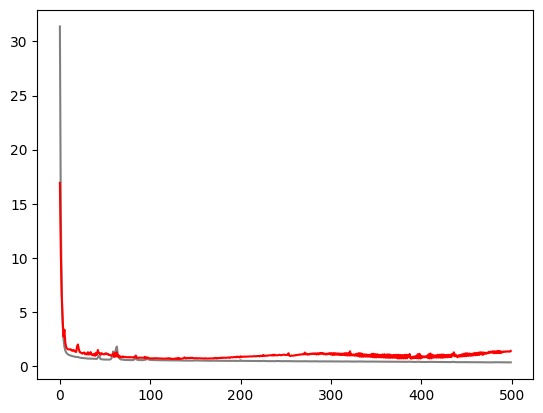

In [38]:
plt.plot(train_history, 'gray')
plt.plot(valid_history, 'r')

### Evaluate Model

In [39]:
# train_pred = model.predict(X_train)
def standardize_output(arr):
    return (1 / (1 + np.e ** (-1 * arr)))

def find_best_prob(pred_prob, actual):
    best_prob = 0
    best_ratio = np.inf
    prob_interval = 0.05
    with np.errstate(divide='ignore'):
        for i in np.arange(0, 1.0, prob_interval):
            pred = pred_prob > i
            metrics = get_metrics(pred, actual, display=False)
            
            PLR = metrics[6]
            NLR = metrics[7]
            ratio = (PLR + NLR)/2

            print(f"{i:.2f}\t{ratio:0.3f}\t{((metrics[0] + metrics[3]) / np.sum(metrics[:4]) * 100):.2f}\t{metrics[:4]}")

            if (ratio < best_ratio):
                best_ratio = ratio
                best_prob = i
    return best_prob

In [40]:
valid_pred_raw = model(X_valid_tensor).detach().numpy()[:,0]
valid_pred_prob = standardize_output(valid_pred_raw)
threshold = find_best_prob(valid_pred_prob, y_valid)
valid_pred = valid_pred_prob > threshold
print(f"Best Threshold: {threshold}")

test_pred_raw = model(X_test_tensor).detach().numpy()[:,0]
test_pred_prob = standardize_output(test_pred_raw)
test_pred = test_pred_prob > threshold

0.00	inf	21.38	[0, 375, 0, 102]
0.05	inf	21.17	[0, 375, 1, 101]
0.10	185.663	21.38	[1, 374, 1, 101]
0.15	185.663	21.38	[1, 374, 1, 101]
0.20	46.421	22.01	[4, 371, 1, 101]
0.25	10.135	24.53	[18, 357, 3, 99]
0.30	1.069	66.04	[226, 149, 13, 89]
0.35	1.003	76.73	[292, 83, 28, 74]
0.40	1.061	77.99	[312, 63, 42, 60]
0.45	1.180	80.08	[332, 43, 52, 50]
0.50	1.524	79.45	[344, 31, 67, 35]
0.55	2.291	78.41	[352, 23, 80, 22]
0.60	3.853	78.62	[362, 13, 89, 13]
0.65	6.279	78.62	[367, 8, 94, 8]
0.70	12.600	78.41	[370, 5, 98, 4]
0.75	25.238	78.20	[371, 4, 100, 2]
0.80	inf	77.78	[371, 4, 102, 0]
0.85	inf	77.99	[372, 3, 102, 0]
0.90	inf	78.20	[373, 2, 102, 0]
0.95	inf	78.20	[373, 2, 102, 0]
Best Threshold: 0.35000000000000003


In [41]:
print("Validation:")
get_metrics(valid_pred, y_valid)
print("===========================")
print("Testing:")
get_metrics(test_pred, y_test)

Validation:
Accuracy: 0.7673
tn:  292,  fp:  83,  fn:  28, tp:  74
Precision:			0.47134
Recall:				0.72549
TPR:				0.72549
FPR:				0.77867
Positive likelihood ratio:	0.93171
Negative likelihood ratio:	1.07330
Testing:
Accuracy: 0.7315
tn:  373,  fp:  125,  fn:  35, tp:  63
Precision:			0.33511
Recall:				0.64286
TPR:				0.64286
FPR:				0.74900
Positive likelihood ratio:	0.85829
Negative likelihood ratio:	1.16510
